<a href="https://colab.research.google.com/github/hwangho-kim/LLM-AD/blob/master/%EA%B3%A8%EB%93%A0_%ED%8A%B8%EB%A0%88%EC%9D%B4%EC%8A%A4_%EC%84%A0%EC%A0%95_%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EC%BD%94%EB%93%9C_(%EC%98%A4%EB%A5%98_%EC%88%98%EC%A0%95).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 0: 가상 FDC 데이터 및 수율 데이터 생성 중...
100개의 가상 데이터 생성 완료.

Step 1: DBSCAN 클러스터링으로 메인 클러스터 식별 중...
클러스터링 결과 (레이블: 샘플 수): {np.int64(0): np.int64(20), np.int64(1): np.int64(80)}
가장 큰 클러스터(메인 클러스터) 레이블: 1
후보군으로 80개의 트레이스 선정 완료.

Step 2: 후보군 내에서 수율이 가장 높은 Golden Trace 선정 중...
최종 Golden Trace 인덱스: 44
해당 트레이스의 수율: 99.00%
선정 이유: 가장 대표적인 공정 패턴 그룹(메인 클러스터)에 속하면서, 동시에 가장 높은 수율을 기록함.

Step 3: 결과 시각화 중...


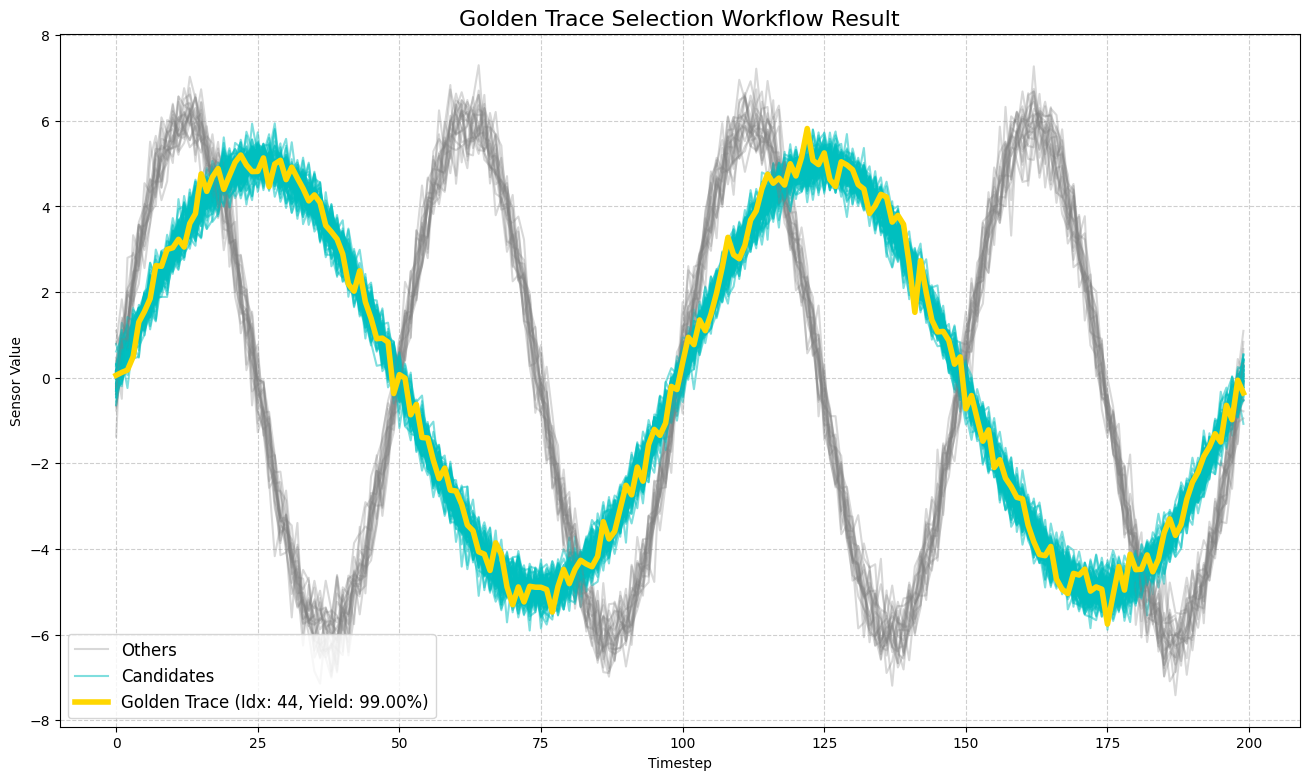

스크립트 실행 완료.


In [1]:
# =============================================================================
# Golden Trace 선정 자동화 스크립트
# =============================================================================
#
# 목적: 대량의 FDC(Fault Detection and Classification) 데이터 중에서
#      가장 이상적인 공정 패턴인 '골든 트레이스'를 효율적으로 선정합니다.
#
# 워크플로우:
# 1. 클러스터링(DBSCAN)을 통해 통계적으로 가장 대표적인 '후보군'을 자동으로 필터링.
# 2. 후보군 내에서 실제 후공정 데이터(수율 등)가 가장 우수한 샘플을 최종 골든 트레이스로 선정.
#
# =============================================================================

# --- 사전 준비: 라이브러리 설치 ---
# 아래 라이브러리들이 설치되어 있지 않다면, 터미널(명령 프롬프트)에서 아래 명령어를 실행해주세요.
# pip install scikit-learn numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# --- 0. 가상 데이터 생성 ---
# 이 부분은 실제 데이터를 로드하는 코드로 대체되어야 합니다.
# - traces: (웨이퍼 수, 각 Trace의 길이) 형태의 2D NumPy 배열
# - yields: (웨이퍼 수,) 형태의 1D NumPy 배열
def generate_mock_data(num_samples=100, timesteps=200):
    """
    시연을 위한 가상의 FDC 트레이스 및 수율 데이터를 생성합니다.
    - 80%는 유사한 패턴의 '정상' 그룹 (높은 수율)
    - 20%는 다른 패턴의 '비정상' 그룹 (낮은 수율)
    """
    print("Step 0: 가상 FDC 데이터 및 수율 데이터 생성 중...")

    # 기준이 되는 이상적인 트레이스 형태 정의
    true_golden_trace = 5 * np.sin(np.linspace(0, 4 * np.pi, timesteps))

    # 정상 트레이스 그룹 생성 (메인 클러스터가 될 그룹)
    num_normal = int(num_samples * 0.8)
    normal_traces = [true_golden_trace + np.random.normal(0, 0.3, timesteps) for _ in range(num_normal)]
    normal_yields = np.random.uniform(90, 99, num_normal)

    # 비정상 트레이스 그룹 생성
    num_abnormal = num_samples - num_normal
    abnormal_pattern = 6 * np.sin(np.linspace(0, 8 * np.pi, timesteps))
    abnormal_traces = [abnormal_pattern + np.random.normal(0, 0.5, timesteps) for _ in range(num_abnormal)]
    abnormal_yields = np.random.uniform(70, 85, num_abnormal)

    # 데이터 합치기
    traces = np.array(normal_traces + abnormal_traces)
    yields = np.concatenate([normal_yields, abnormal_yields])

    # 데이터 순서를 무작위로 섞어 현실성을 높임
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    print(f"{num_samples}개의 가상 데이터 생성 완료.\n")
    return traces[indices], yields[indices]

# 가상 데이터 생성 함수 호출
traces, yields = generate_mock_data()


# --- 1단계: 클러스터링을 통한 데이터 기반 후보군 축소 ---
print("Step 1: DBSCAN 클러스터링으로 메인 클러스터 식별 중...")

# DBSCAN 모델 생성 및 학습
# [수정됨] eps: 두 샘플이 이웃으로 간주되기 위한 최대 거리.
# 이 값이 너무 작으면 모든 데이터가 노이즈(-1)로 처리될 수 있습니다.
# 데이터의 분산에 따라 적절한 값으로 튜닝이 필요하며, 기존 5에서 10으로 상향 조정했습니다.
# min_samples: 하나의 군집을 형성하기 위해 필요한 최소 샘플(데이터 포인트)의 수.
dbscan = DBSCAN(eps=10, min_samples=10)
clusters = dbscan.fit_predict(traces)

# 클러스터링 결과 요약
# -1 레이블은 어떤 클러스터에도 속하지 않는 노이즈(이상치)를 의미합니다.
unique_labels, counts = np.unique(clusters, return_counts=True)
cluster_summary = dict(zip(unique_labels, counts))
print(f"클러스터링 결과 (레이블: 샘플 수): {cluster_summary}")

# 가장 큰 클러스터(메인 클러스터) 찾기. 노이즈(-1)는 제외합니다.
main_cluster_label = -1
max_count = 0
# items()를 사용해 딕셔너리의 키(label)와 값(count)을 순회
for label, count in cluster_summary.items():
    if label != -1 and count > max_count:
        max_count = count
        main_cluster_label = label

# 메인 클러스터가 없는 경우 에러 처리
if main_cluster_label == -1:
    raise ValueError("메인 클러스터를 찾지 못했습니다. DBSCAN의 eps나 min_samples 파라미터를 조정해보세요.")

# 메인 클러스터에 속한 트레이스들의 인덱스(위치)를 추출
candidate_indices = np.where(clusters == main_cluster_label)[0]
print(f"가장 큰 클러스터(메인 클러스터) 레이블: {main_cluster_label}")
print(f"후보군으로 {len(candidate_indices)}개의 트레이스 선정 완료.\n")


# --- 2단계: 핵심 후공정 데이터 기반 최종 선정 ---
print("Step 2: 후보군 내에서 수율이 가장 높은 Golden Trace 선정 중...")

# 1단계에서 선정한 후보군에 해당하는 수율 데이터만 필터링
candidate_yields = yields[candidate_indices]

# 후보군 내에서 수율이 가장 높은 트레이스의 '상대적 위치' 찾기 (예: 후보군 50개 중 3번째)
best_in_candidate_idx = np.argmax(candidate_yields)

# '상대적 위치'를 '전체 데이터에서의 실제 인덱스'로 변환
golden_trace_idx = candidate_indices[best_in_candidate_idx]
golden_trace_yield = yields[golden_trace_idx]

print(f"최종 Golden Trace 인덱스: {golden_trace_idx}")
print(f"해당 트레이스의 수율: {golden_trace_yield:.2f}%")
print("선정 이유: 가장 대표적인 공정 패턴 그룹(메인 클러스터)에 속하면서, 동시에 가장 높은 수율을 기록함.\n")


# --- 3. 결과 시각화 ---
print("Step 3: 결과 시각화 중...")
plt.figure(figsize=(16, 9))
plt.title("Golden Trace Selection Workflow Result", fontsize=16)

# 전체 트레이스 그리기
num_samples = traces.shape[0]
for i in range(num_samples):
    # 메인 클러스터에 속한 후보군 트레이스는 하늘색으로 표시
    if i in candidate_indices:
        # label은 범례에 한 번만 표시하기 위한 트릭
        plt.plot(traces[i], color='c', alpha=0.5, label='Candidates' if i == candidate_indices[0] else "")
    # 그 외 트레이스(노이즈 또는 다른 클러스터)는 회색으로 표시
    else:
        # np.where의 결과는 튜플이므로 [0]으로 인덱싱 필요
        other_indices = np.where(clusters != main_cluster_label)[0]
        # other_indices가 비어있지 않을 때만 label을 추가
        if len(other_indices) > 0:
            plt.plot(traces[i], color='gray', alpha=0.3, label='Others' if i == other_indices[0] else "")
        else:
            plt.plot(traces[i], color='gray', alpha=0.3)


# 최종 선정된 Golden Trace는 금색으로 굵게 강조하여 표시
plt.plot(traces[golden_trace_idx], color='gold', linewidth=4, label=f'Golden Trace (Idx: {golden_trace_idx}, Yield: {golden_trace_yield:.2f}%)')

plt.xlabel("Timestep")
plt.ylabel("Sensor Value")
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("스크립트 실행 완료.")